In [61]:
import pandas as pd
import numpy as np

import config
from psycopg.rows import dict_row
from getdata import pgDictToConn, getTicker

In [63]:
import strategy.trendlabeling as tlb
import afml.filters.filters as flt 
import afml.labeling.triplebarrier as tbar
import afml.util.volatility as vol
import features.bars as bars  
import features.marketindicators as mkt
from afml.sample_weights.attribution import get_weights_by_return
from afml.cross_validation.cross_validation import PurgedKFold
import crossvalidation as cv

In [64]:
import matplotlib.pyplot as plt
import mplfinance as mpl
%matplotlib inline

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay

import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

## Import Dataset

In [66]:
#Init
pgConnStr = pgDictToConn(config.pgSecrets)

df = getTicker('STBA')
df.index = pd.to_datetime(df.datetime)

index_SPY = getTicker('SPY')
index_SPY.index = pd.to_datetime(index_SPY.datetime)

In [67]:
df.shape

(16914, 11)

## Resampling as Dollar Bars

In [68]:
# construct the input data
trades = df[['datetime', 'close', 'vol']].to_numpy()

# define the dollar value to sample the data - we want to resample about 50 bars per day based on the average of last 10 days' dollar volume
dollar_vol = (df['vol']*df['close']).resample('D').sum()[:-10].mean()/50.0

# generate the dollar bars
dollar_bars = bars.generate_dollarbars(trades, frequency=dollar_vol) 


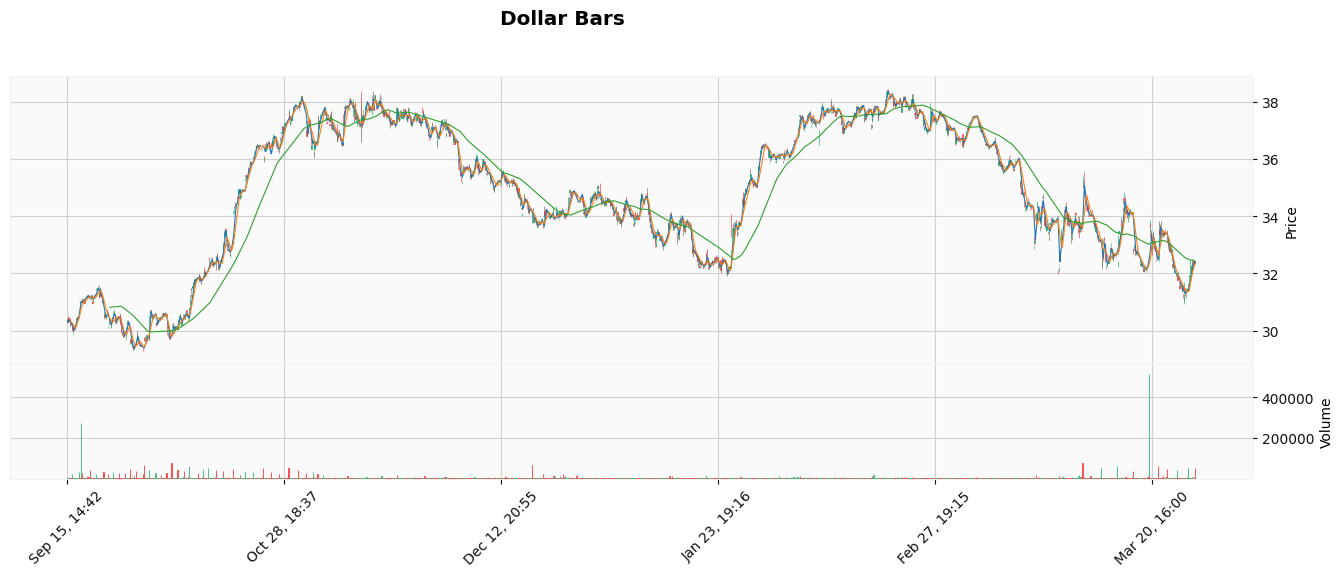

In [69]:
mpl.plot(dollar_bars, # the dataframe containing the OHLC (Open, High, Low and Close) data
         type='candle', # use candlesticks 
         volume=True, # also show the volume
         mav=(9,20,200), # use three different moving averages
         figratio=(3,1), # set the ratio of the figure
         style='yahoo',  # choose the yahoo style
         title='Dollar Bars')

In [70]:
# we then do the same for SPY index as well for calculating relative strength as feature in Model 2 
trades_SPY = index_SPY[['datetime', 'close', 'vol']].to_numpy()
dollar_vol_SPY = (index_SPY['vol']*index_SPY['close']).resample('D').sum()[:10].mean()/50.0
dollar_bars_SPY = bars.generate_dollarbars(trades_SPY, frequency=dollar_vol_SPY) 


## Model 1: Trend Scanning to label as Uptrend or Downtrend

In [71]:
# get close values of dollar bars
time_series = dollar_bars.close.to_numpy()

# set window size to calculate best slope
window_size_max= 7

# get trend scanning labels
label_output = pd.DataFrame(tlb.get_trend_scanning_labels(time_series=time_series, 
                                             window_size_max=window_size_max, 
                                             threshold=0.0,
                                             opp_sign_ct=3,
                                             side='both'), 
                            index= dollar_bars.index[window_size_max-1:])

# put label results back into dollar_bars Dataframe 
dollar_bars = dollar_bars.join(label_output, how='outer')

# remove look-ahead bias
dollar_bars['label'] = dollar_bars['label'].shift(1) 
dollar_bars['slope'] = dollar_bars['slope'].shift(1) 

In [72]:
# number of uptrends vs # of downtrends
print(dollar_bars['label'].value_counts())

 1.0    2663
-1.0    2532
Name: label, dtype: int64


## Get Trade Triggering Events based on Volitility Threshold

In [73]:
# Dollar bar close data
close = dollar_bars.close.copy()

# get Daily Volatility as 50 dollar bars exponentially weighted moving std dev
dailyVolatility = vol.getDailyVol(close, span=50)

# apply cusum filter to identify events as cumulative log return passed daily volatility threshold
tEvents = flt.cusum_filter(close, threshold=dailyVolatility.mean()*0.5, signal=None)

# Define vertical barrier - this is subjective, we will close out the position if after a day
num_days = 1

t1 = tbar.add_vertical_barrier(tEvents, close, num_days=num_days)

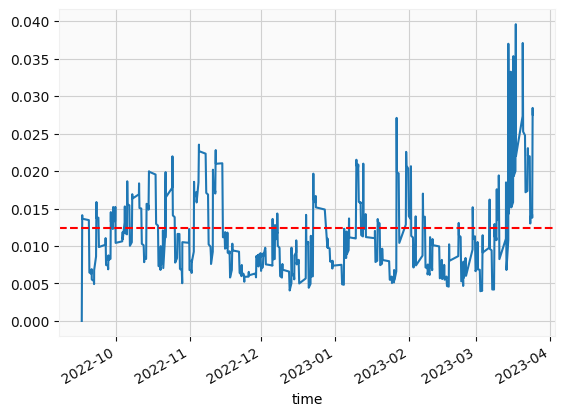

In [74]:
# show volitility over time

f,ax = plt.subplots()
dailyVolatility.plot(ax=ax)
ax.axhline(dailyVolatility.mean(),ls='--',color='r')

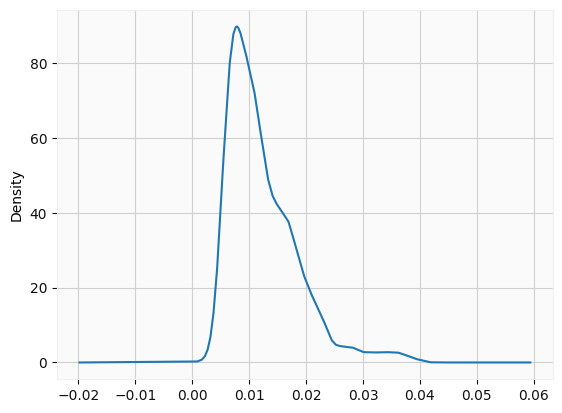

In [75]:
#show distribution of volitility
ax = dailyVolatility.plot.kde()

In [76]:
# get side labels from trend following method for inputting into the trend following method
side_labels = []

for dt in dollar_bars.index:
    side_labels.append(dollar_bars.loc[dt]['label'])

side_labels = pd.Series(side_labels, index=dollar_bars.index)

## Create Trade or Not Trade labels using Triple Barrier Method

In [77]:
# Define upper and lower horizontal barriers

# set profit and stop loss ratio, 2:1 is the common trader's ratio
ptsl = [1.5,1]

# set minimum desired return
# requires at least 1.5% percent return fro transaction and slippage
minRet = 0.015 

# Run in single-threaded mode on Windows
import platform, os
if platform.system() == "Windows":
    cpus = 1
else:
    cpus = os.cpu_count() - 1
    
events = tbar.get_events(dollar_bars.close, 
                         t_events=tEvents, 
                         pt_sl=ptsl, 
                         target=dailyVolatility, 
                         min_ret=minRet, 
                         num_threads=cpus, 
                         vertical_barrier_times=t1,
                         side_prediction=side_labels).dropna()

# get the triple barrier labels 1 means above minimum return, 0 otherwise.
labels = tbar.get_bins(triple_barrier_events = events, close=close)

# Drop underpopulated labels
clean_labels  = tbar.drop_labels(labels)
print(clean_labels.bin.value_counts())

0    189
1     47
Name: bin, dtype: int64


Data is so imbalance.

## Results of Model 1 without features

Based on the Trend Labeling method, assuming we close out our position within 24 hours and we require a 1.5:1 profit ratio. If we bet on every single uptrend or downtrend signal, our accuracy is only at 20 percent. 

In [78]:
primary_forecast = pd.DataFrame(clean_labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       189
           1       0.20      1.00      0.33        47

    accuracy                           0.20       236
   macro avg       0.10      0.50      0.17       236
weighted avg       0.04      0.20      0.07       236

Confusion Matrix
[[  0 189]
 [  0  47]]

Accuracy
0.19915254237288135


## Adding more features to the dataset for Model 2

In [79]:
# Log Returns
dollar_bars['log_ret'] = np.log(dollar_bars['close']).diff().shift(1)

# Momentum
dollar_bars['mom1'] = dollar_bars['close'].pct_change(periods=1).shift(1)
dollar_bars['mom2'] = dollar_bars['close'].pct_change(periods=2).shift(1)
dollar_bars['mom3'] = dollar_bars['close'].pct_change(periods=3).shift(1)
dollar_bars['mom4'] = dollar_bars['close'].pct_change(periods=4).shift(1)
dollar_bars['mom5'] = dollar_bars['close'].pct_change(periods=5).shift(1)

# Volatility
dollar_bars['volatility_50'] = dollar_bars['log_ret'].rolling(window=50, min_periods=50, center=False).std().shift(1)
dollar_bars['volatility_31'] = dollar_bars['log_ret'].rolling(window=31, min_periods=31, center=False).std().shift(1)
dollar_bars['volatility_15'] = dollar_bars['log_ret'].rolling(window=15, min_periods=15, center=False).std().shift(1)

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

dollar_bars['autocorr_1'] = dollar_bars['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False).shift(1)
dollar_bars['autocorr_2'] = dollar_bars['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False).shift(1)
dollar_bars['autocorr_3'] = dollar_bars['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False).shift(1)
dollar_bars['autocorr_4'] = dollar_bars['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False).shift(1)
dollar_bars['autocorr_5'] = dollar_bars['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False).shift(1)

# Get the various log -t returns
dollar_bars['log_t1'] = dollar_bars['log_ret'].shift(1).shift(1)
dollar_bars['log_t2'] = dollar_bars['log_ret'].shift(2).shift(1)
dollar_bars['log_t3'] = dollar_bars['log_ret'].shift(3).shift(1)
dollar_bars['log_t4'] = dollar_bars['log_ret'].shift(4).shift(1)
dollar_bars['log_t5'] = dollar_bars['log_ret'].shift(5).shift(1)

# relative strength SPY at various -t
dollar_bars['rs_SPY_t1'] = mkt.get_relative_strength(dollar_bars.close, dollar_bars_SPY.close).shift(1)
dollar_bars['rs_SPY_t2'] = mkt.get_relative_strength(dollar_bars.close, dollar_bars_SPY.close).shift(2)
dollar_bars['rs_SPY_t3'] = mkt.get_relative_strength(dollar_bars.close, dollar_bars_SPY.close).shift(3)
dollar_bars['rs_SPY_t4'] = mkt.get_relative_strength(dollar_bars.close, dollar_bars_SPY.close).shift(4)
dollar_bars['rs_SPY_t5'] = mkt.get_relative_strength(dollar_bars.close, dollar_bars_SPY.close).shift(5)



## Model 2 - Model Fitting

#### Use features: volatility, serial correlation, relative strength to S&P, and original Model 1 slope and trend label

In [80]:
dollar_bars = dollar_bars.join(clean_labels['bin']).dropna()

In [81]:
X = dollar_bars.iloc[:, :-1]
y = dollar_bars.iloc[:, -1]

col = ['slope', 'label', 'log_ret',
       'mom1', 'mom2', 'mom3', 'mom4', 'mom5', 'volatility_50',
       'volatility_31', 'volatility_15', 'autocorr_1', 'autocorr_2',
       'autocorr_3', 'autocorr_4', 'autocorr_5', 'log_t1', 'log_t2', 'log_t3',
       'log_t4', 'log_t5', 'rs_SPY_t1', 'rs_SPY_t2', 'rs_SPY_t3', 'rs_SPY_t4',
       'rs_SPY_t5']

X = X[col]

In [82]:
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=RANDOM_STATE)

#### Due to Label Concurrency, we will apply custom sample weights to the training

In [83]:
# training data sample weights
return_based_sample_weights = get_weights_by_return(events.loc[X_train.index], dollar_bars.loc[X_train.index, 'close'])

# test data sample weights
return_based_sample_weights_test = get_weights_by_return(events.loc[X_test.index], dollar_bars.loc[X_test.index, 'close'])

2023-03-27 18:53:13.557518 100.0% num_concurrent_events done after 0.01 minutes. Remaining 0.0 minutes.
2023-03-27 18:53:14.646547 100.0% _apply_weight_by_return done after 0.01 minutes. Remaining 0.0 minutes.
2023-03-27 18:53:15.723253 100.0% num_concurrent_events done after 0.01 minutes. Remaining 0.0 minutes.
2023-03-27 18:53:16.855280 100.0% _apply_weight_by_return done after 0.01 minutes. Remaining 0.0 minutes.


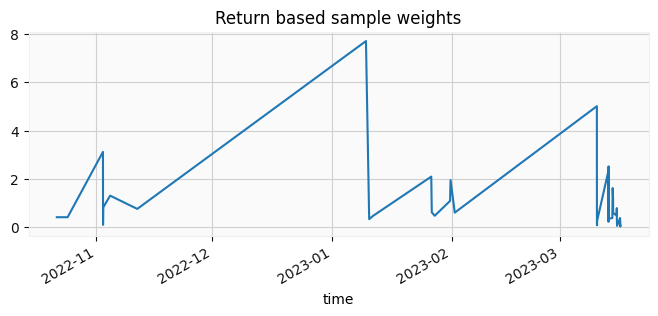

In [84]:
plt.figure(figsize=(8,3))
plt.title('Return based sample weights')
return_based_sample_weights.plot()
plt.show()

#### Model Selection and Cross Validation

In [85]:
# setup parameters for cross validation
parameters = {'max_depth':[3, 5, 7, 9],
              'n_estimators':[10, 50, 100, 250, 500],
              'C':[100,
                   1000],
              'gamma':[0.001,
                       0.0001], 
              }

In [86]:
# setup the Purged K Fold splits needed for cross validation
n_splits=4
cv_gen_purged = PurgedKFold(n_splits=n_splits, samples_info_sets=events.loc[X_train.index].t1)

In [87]:
warnings.filterwarnings('ignore')

In [88]:
# models we want to test
selected_models = ['standard_bagging', # with base clf as Decision Tree Classifier
                   'random_forest', # Random Forest without bagging
                   'sequential_bootstrapping', # bagging using sequential bootstrapping method with base clf as Decision Tree Classifier
                   'SVC', # standard SVC
                   'seq_boot_SVC' # bagging using sequential bootstrapping method with base clf as Decision Tree Classifier SVC
                   # RNN
                   # BERT
                   ]

# setup metrics df
model_metrics = pd.DataFrame(columns = ['type', 'top_model', 'max_cross_val_score', 'max_cross_val_score_recall', 'max_cross_val_score_precision', 'max_cross_val_score_accuracy','run_time'])

# let's find out the best parameters and the best model!
for clf in selected_models:
    best_params = cv.perform_grid_search(X_train, y_train, cv_gen_purged, 'f1', parameters, events, dollar_bars, type=clf, sample_weight=return_based_sample_weights.values)
    model_metrics = model_metrics.append(best_params, ignore_index = True)  
    print('Completed {}'.format(clf))


Completed standard_bagging
Completed random_forest
Completed sequential_bootstrapping
Completed SVC
Completed seq_boot_SVC


In [89]:
model_metrics

,type,top_model,max_cross_val_score,max_cross_val_score_recall,max_cross_val_score_precision,max_cross_val_score_accuracy,run_time
0,standard_bagging,(DecisionTreeClassifier(class_weight='balanced...,0.250000,0.250000,0.250000,0.635317,0.887203
1,random_forest,"(DecisionTreeClassifier(criterion='entropy', m...",0.250000,0.250000,0.250000,0.635317,3.247198
2,sequential_bootstrapping,(DecisionTreeClassifier(class_weight='balanced...,0.250000,0.250000,0.250000,0.635317,1.543049
3,SVC,"SVC(C=1000, class_weight='balanced', gamma=0.0...",0.384519,0.628568,0.395202,0.593187,0.039031
4,seq_boot_SVC,"(SVC(C=1000, class_weight='balanced', gamma=0....",0.376888,0.598224,0.354378,0.657796,0.140661


In [90]:
# model with the best f1 score
top_model = model_metrics.sort_values(['max_cross_val_score_recall']).tail(1)['top_model'].squeeze()
top_model

SVC(C=1000, class_weight='balanced', gamma=0.0001, kernel='linear',
    random_state=42)

In [91]:

best_SVC = model_metrics[model_metrics['type'] == 'seq_boot_SVC']['top_model'].squeeze()
best_SVC

SequentiallyBootstrappedBaggingClassifier(estimator=SVC(C=1000,
                                                        class_weight='balanced',
                                                        gamma=0.0001,
                                                        kernel='linear',
                                                        random_state=42),
                                          n_jobs=-1,
                                          price_bars=time
2022-10-21 19:08:00    34.875
2022-10-24 14:30:00    35.330
2022-11-02 18:03:00    37.240
2022-11-02 18:36:00    37.150
2022-11-02 19:49:00    36.660
2022-11-04 14:41:00    37.450
2022-11-11 15:17:00    37.910
2023-01-09 20:02:00    33.290...
2023-03-15 16:37:00   2023-03-15 18:37:00
2023-03-15 18:27:00   2023-03-16 16:54:00
2023-03-15 18:51:00   2023-03-16 16:50:00
2023-03-15 19:59:00   2023-03-16 14:55:00
2023-03-16 14:56:00   2023-03-16 16:54:00
2023-03-16 15:29:00   2023-03-16 16:58:00
2023-03-16 15:53:00   2023-03-16 17:07:00
2023-03-16 16:09:00   2023-03-16 17:07:00
2023-03-16 16:50:00   2023-03-16 17:07:00
Name: t1, dtype: datetime64[ns])

We will use the Sequential Bootstrapped SVC classfier as the base model outperforms tree-based classifiers. Sequential Bootstrapping helps avoid overfitting by lowering down the probability of resampling repeated data during the bagging process.

## Feature Importance

The SVC classifier does not provide a direct wat to obtain feature importances. However, we can use the coefficients of the hyperplane that seperates the classes to estimate the importance of each feature. The magnitude of the coefficient corresponds to the importance of the corresponding feature in the classification.

In [92]:
# todo

# Get coefficients of hyperplane
coef = best_SVC.coef_.ravel()
indices = np.argsort(coef)
coef = coef[indices]
feature_names = X_train.columns.to_list()
feature_names = [feature_names[i] for i in indices]

# Plot the coefficients as horizontal bars
plt.barh(range(len(coef)), coef, color='b')

# Add a horizontal line to indicate standard deviation
plt.plot([0, 0], [len(coef), -1], 'r--', lw=2)

# Set the y-axis labels
plt.yticks(range(len(coef)), feature_names)

# Set the x-axis label and title
plt.xlabel('Coefficient')
plt.title('Feature Importance')

plt.show()


AttributeError: 'SequentiallyBootstrappedBaggingClassifier' object has no attribute 'coef_'

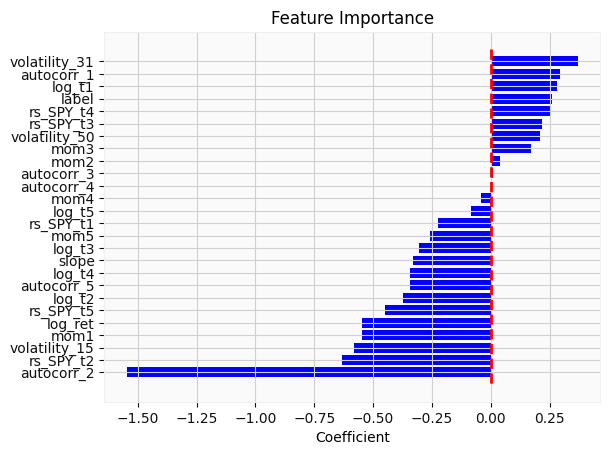

In [93]:
# Get coefficients of hyperplane
coef = top_model.coef_.ravel()
indices = np.argsort(coef)
coef = coef[indices]
feature_names = X_train.columns.to_list()
feature_names = [feature_names[i] for i in indices]

# Plot the coefficients as horizontal bars
plt.barh(range(len(coef)), coef, color='b')

# Add a horizontal line to indicate standard deviation
plt.plot([0, 0], [len(coef), -1], 'r--', lw=2)

# Set the y-axis labels
plt.yticks(range(len(coef)), feature_names)

# Set the x-axis label and title
plt.xlabel('Coefficient')
plt.title('Feature Importance')

plt.show()

## Top Model Metrics

#### The test data is a bit too small to evaluate the prediction results.

              precision    recall  f1-score   support

         0.0       0.75      0.75      0.75         8
         1.0       0.33      0.33      0.33         3

    accuracy                           0.64        11
   macro avg       0.54      0.54      0.54        11
weighted avg       0.64      0.64      0.64        11



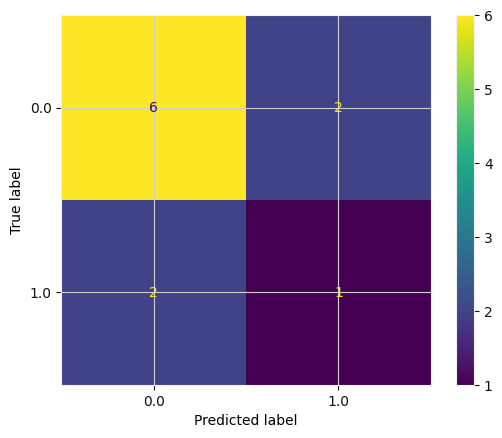

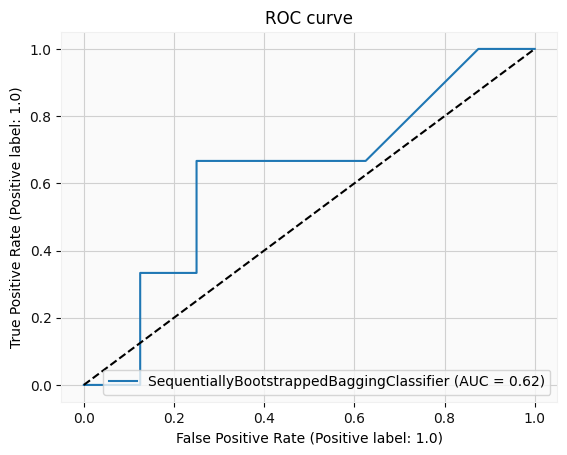

In [95]:
y_pred = best_SVC.predict(X_test)
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(best_SVC, X_test, y_test)
plt.show()

SVC_ROC = RocCurveDisplay.from_estimator(best_SVC, X_test, y_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC curve')
plt.show()

## Backtesting Results

In [97]:
# prep the dataframe
results_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred}, index=X_test.index)
X_test_with_results = pd.concat([X_test, results_df], axis=1)
merged_df = pd.merge(X_test_with_results, clean_labels, left_index=True, right_index=True)

In [98]:
# trade returns of predicted trades 
transaction_cost = 0.01
slippage = 0.005

merged_df['y_pred_trade_ret'] = 0
merged_df.loc[merged_df['y_pred'] == 1, 'y_pred_trade_ret'] = merged_df.loc[merged_df['y_pred'] == 1, 'ret'] - (transaction_cost + slippage)
merged_df_sorted = merged_df.sort_values('t1')


In [99]:
# cumulative returns
merged_df_sorted['cumulative_returns'] = (merged_df_sorted['y_pred_trade_ret'] + 1).cumprod() - 1
cum_rtn_plot = merged_df_sorted.groupby('t1')['cumulative_returns', 'y_pred_trade_ret'].last()
cum_rtn_plot = pd.DataFrame(cum_rtn_plot)

### Cumulative Returns

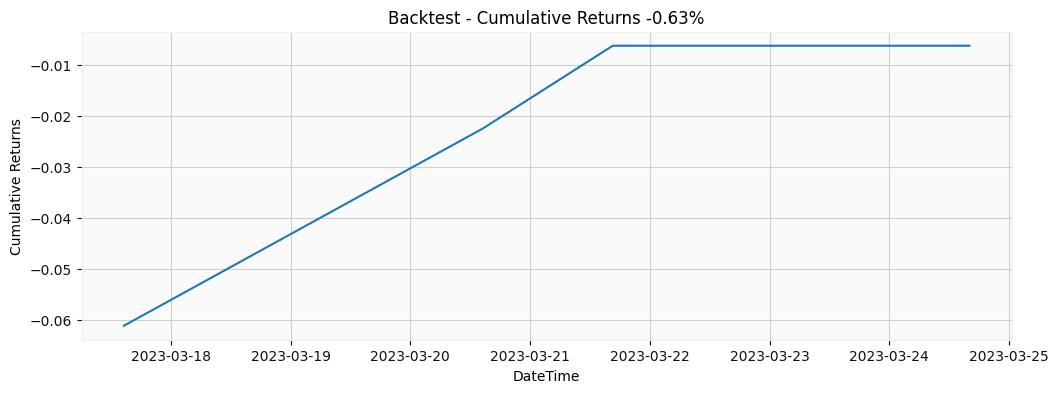

In [107]:
# Visualize the results
plt.figure(figsize=(12, 4))
plt.plot(cum_rtn_plot.index, cum_rtn_plot.cumulative_returns)

plt.xlabel('DateTime')
plt.ylabel('Cumulative Returns')
plt.hlines(y=0, xmin=None, xmax=None, colors='r', linestyles='--')
plt.title('Backtest - Cumulative Returns {}'.format(str(round(cum_rtn_plot.iloc[-1].cumulative_returns*100,2))+'%'))
plt.show()

#### Sharpe Ratio (work in progress)

In [71]:
# https://ycharts.com/indicators/3_year_treasury_rate Long Term Average Rist Free Rate as at Mar 24, 2023
daily_risk_free_rate = 0.036 / 252  # https://ycharts.com/indicators/3_year_treasury_rate Long Term Average Rist Free Rate as at Mar 24, 2023

# calculate daily returns for each trading day
trading_days = pd.DataFrame(pd.bdate_range(start=merged_df.index.min(), end=cum_rtn_plot.index.max(), freq='B'), columns=['trading_days'])
trading_days.index =trading_days['trading_days']
sharpe_df = pd.merge(trading_days, cum_rtn_plot['cumulative_returns'], left_index=True, right_index=True, how='left').fillna(method='ffill')
sharpe_df['cumulative_returns'] = sharpe_df['cumulative_returns'].fillna(0)
sharpe_df['daily_returns'] = sharpe_df['cumulative_returns'].diff().fillna(0)
sharpe_df['day'] = 1
sharpe_df['trading_days'] = sharpe_df['day'].cumsum()
sharpe_df['rolling_std_dev'] =sharpe_df['daily_returns'].expanding().std(ddof=0)
sharpe_df['cumulative_sharpe'] = ((sharpe_df['cumulative_returns']/sharpe_df['trading_days'])-daily_risk_free_rate) / sharpe_df['rolling_std_dev'] * np.sqrt(252)
sharpe_df = sharpe_df.fillna(0)


In [72]:
# Calculate the average daily return and standard deviation of daily returns
avg_daily_return = np.mean(sharpe_df.daily_returns)
std_daily_return = np.std(sharpe_df.daily_returns)

# Calculate the Sharpe ratio
daily_risk_free_rate = 0.036 / 252  
sharpe_ratio = round((avg_daily_return - daily_risk_free_rate) / std_daily_return * np.sqrt(252), 2)

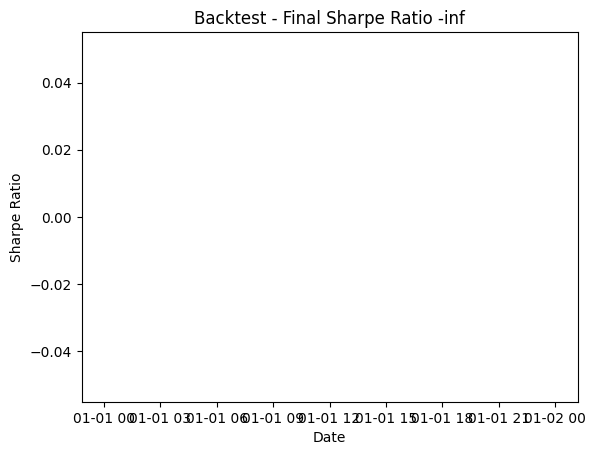

In [73]:
plt.plot(sharpe_df.index, sharpe_df['cumulative_sharpe'])
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.title('Backtest - Final Sharpe Ratio {}'.format(sharpe_ratio))
plt.show()